In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df = pd.read_csv("../Data/Copy of hackathon_customerData_challenge2.csv")
df.head()

,customerID,Date_UTC,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C
0,793,2022-10-21T18:00:00.000Z,2022-10-22,15,4099.0,NaN
1,793,2022-10-21T18:15:00.000Z,2022-10-22,15,5566.0,NaN
2,793,2022-10-21T18:30:00.000Z,2022-10-22,16,3565.5,NaN
3,793,2022-10-21T18:45:00.000Z,2022-10-22,16,3420.5,NaN
4,793,2022-10-21T19:00:00.000Z,2022-10-22,17,3236.5,NaN


In [3]:
# Drop rows where laod power is 0
df = df[df['load_power_W'] != 0.0]

In [4]:
# Convert date column from str to datetime
df['Date_UTC'] = pd.to_datetime(df['Date_UTC'])

In [5]:
df['Date_NZDT'] = df['Date_UTC'] + pd.Timedelta(hours=13)
df.insert(2, 'Date_NZDT', df.pop('Date_NZDT'))
df.head()

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN


In [6]:
# Spring = 0
# Summer = 1
# Autumn = 2
# Winter = 3

def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3

# Assuming 'Date_NZDT' is your date column
df['Season'] = df['Date_NZDT'].apply(get_season)
df.head()

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C,Season
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN,2
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN,2
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN,2
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN,2
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN,2


In [7]:
df['average_temp'] = df.groupby(['customerID', 'Date_NZDate'])['weather_Temp_C'].transform(np.mean)
df

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C,Season,average_temp
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN,2,NaN
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN,2,NaN
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN,2,NaN
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN,2,NaN
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN,2,NaN
...,...,...,...,...,...,...,...,...,...
35038979,592,2023-08-24 18:00:00+00:00,2023-08-25 07:00:00+00:00,2023-08-25,13,261.5,0.800,1,6.339105
35038980,592,2023-08-24 18:15:00+00:00,2023-08-25 07:15:00+00:00,2023-08-25,13,459.0,-0.035,1,6.339105
35038981,592,2023-08-24 18:30:00+00:00,2023-08-25 07:30:00+00:00,2023-08-25,14,359.0,-0.870,1,6.339105
35038982,592,2023-08-24 18:45:00+00:00,2023-08-25 07:45:00+00:00,2023-08-25,14,488.0,-1.370,1,6.339105


In [8]:
def day(num):
    return slice((num - 1) * 96, num * 96 + 1)

day(1)

slice(0, 97, None)

383544    14.6100
383545    14.8050
383546    15.0000
383547    15.1950
383548    15.3900
           ...   
383636    14.7400
383637    14.8675
383638    14.9950
383639    15.1225
383640    15.2500
Name: weather_Temp_C, Length: 97, dtype: float64


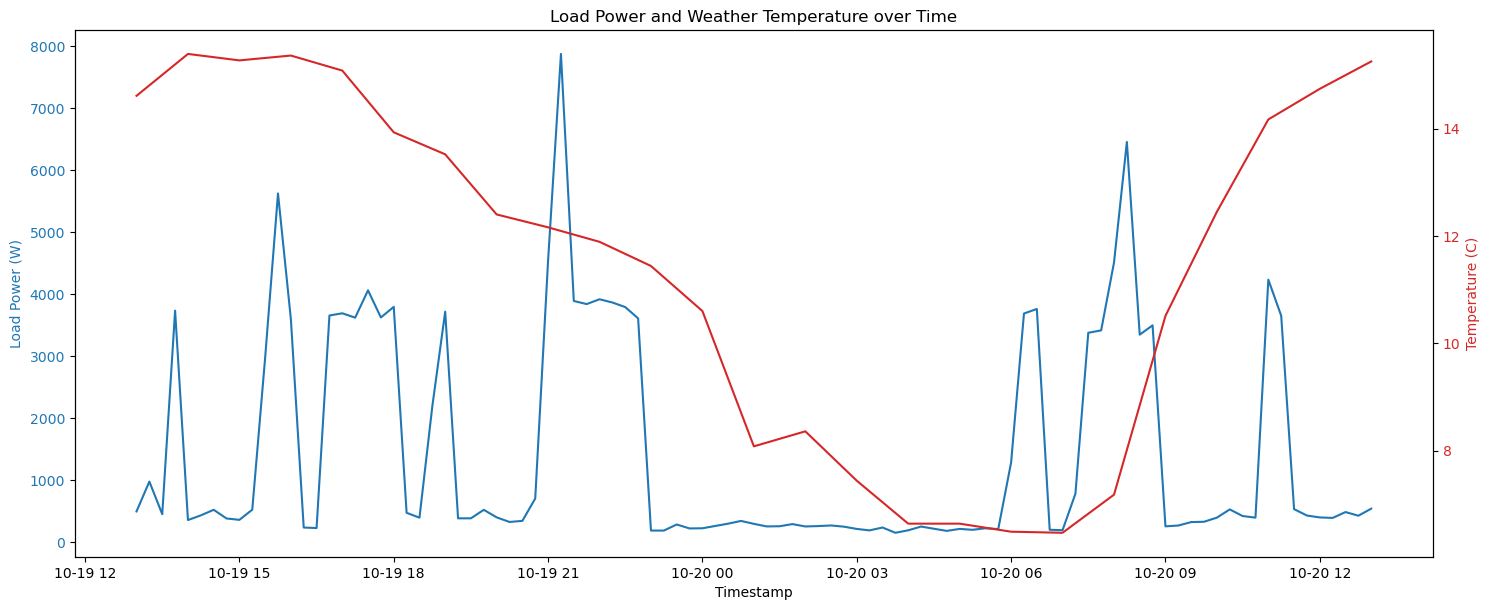

        customerID                  Date_UTC                 Date_NZDT  \
383160         850 2022-10-15 00:00:00+00:00 2022-10-15 13:00:00+00:00   
383161         850 2022-10-15 00:15:00+00:00 2022-10-15 13:15:00+00:00   
383162         850 2022-10-15 00:30:00+00:00 2022-10-15 13:30:00+00:00   
383163         850 2022-10-15 00:45:00+00:00 2022-10-15 13:45:00+00:00   
383164         850 2022-10-15 01:00:00+00:00 2022-10-15 14:00:00+00:00   
383165         850 2022-10-15 01:15:00+00:00 2022-10-15 14:15:00+00:00   
383166         850 2022-10-15 01:30:00+00:00 2022-10-15 14:30:00+00:00   
383167         850 2022-10-15 01:45:00+00:00 2022-10-15 14:45:00+00:00   
383168         850 2022-10-15 02:00:00+00:00 2022-10-15 15:00:00+00:00   
383169         850 2022-10-15 02:15:00+00:00 2022-10-15 15:15:00+00:00   
383170         850 2022-10-15 02:30:00+00:00 2022-10-15 15:30:00+00:00   
383171         850 2022-10-15 02:45:00+00:00 2022-10-15 15:45:00+00:00   
383172         850 2022-10-15 03:00:00

In [50]:
def plot_customer_data(customer_id, day_num):
    df_customer = df[df['customerID'] == customer_id]
    
    fig, ax1 = plt.subplots(figsize=(15, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Load Power (W)', color=color)
    ax1.plot(df_customer['Date_NZDT'][day(day_num)], df_customer['load_power_W'][day(day_num)], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Temperature (C)', color=color)  # we already handled the x-label with ax1
    print(df_customer['weather_Temp_C'][day(day_num)])
    ax2.plot(df_customer['Date_NZDT'][day(day_num)], df_customer['weather_Temp_C'][day(day_num)], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Load Power and Weather Temperature over Time')
    plt.show()

plot_customer_data(850, 5)

print(df[df['customerID'] == 850][0:20])

In [10]:
df.columns

Index(['customerID', 'Date_UTC', 'Date_NZDT', 'Date_NZDate',
       'date_settlementPeriod', 'load_power_W', 'weather_Temp_C', 'Season',
       'average_temp'],
      dtype='object')

<Axes: >

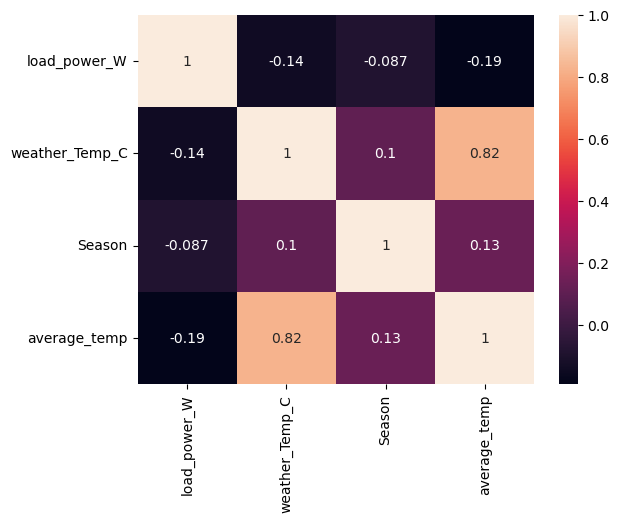

In [11]:
# Assuming df is your DataFrame
correlation_matrix = df[['load_power_W', 'weather_Temp_C', 'Season', 'average_temp']].corr()
sns.heatmap(correlation_matrix, annot=True)


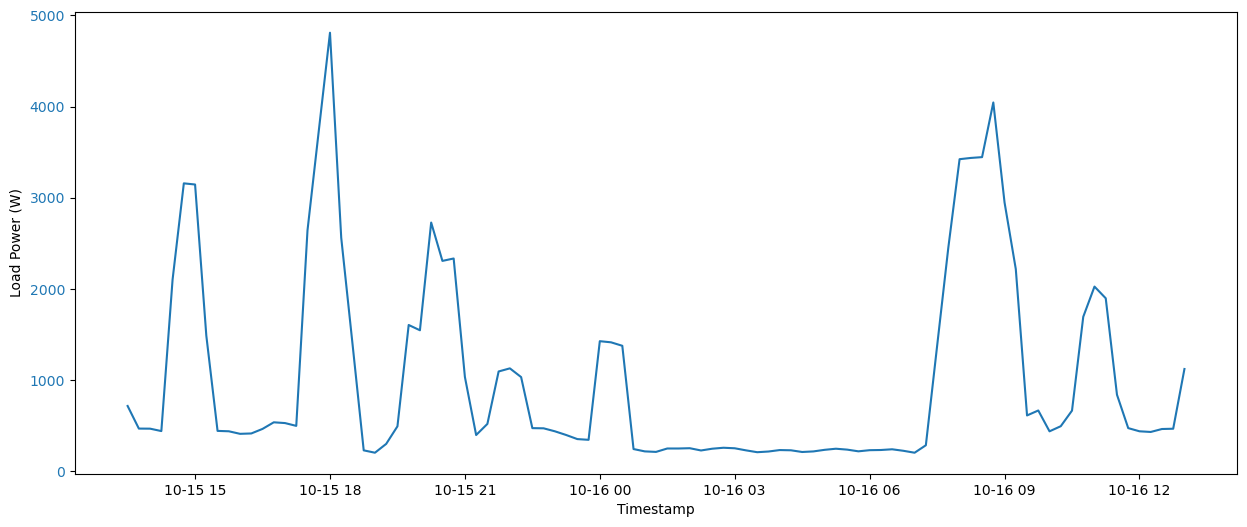

In [12]:
def smoothing_function(column, customer_id, day_num, window_size):
    df_customer = df[df['customerID'] == customer_id]
    smoothed_data = df_customer[column].rolling(window=window_size).mean()
    fig, ax1 = plt.subplots(figsize=(15, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Load Power (W)')
    ax1.plot(df_customer['Date_NZDT'][day(day_num)],smoothed_data[day(day_num)], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

smoothed_data = smoothing_function('load_power_W',850, 1, window_size=3)



This code uses the `ruptures` library to generate a piecewise normal signal and detect change points in it. The detected change points can be interpreted as the times when an appliance was turned on or off.

c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

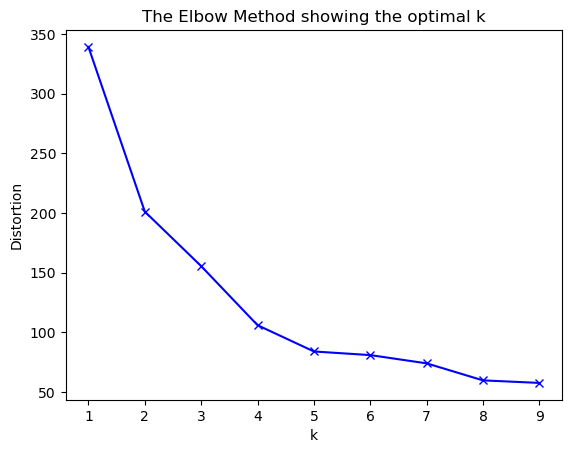

In [13]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

df_no_na_temp = df.dropna(subset=['weather_Temp_C'])

def elbow_method(data):
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(data)
        kmeanModel.fit(data)
        distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

# Assuming 'df' is your DataFrame and you want to find clusters based on 'load_power_W' and 'weather_Temp_C'
elbow_method(df_no_na_temp[['load_power_W']][:1000])

c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

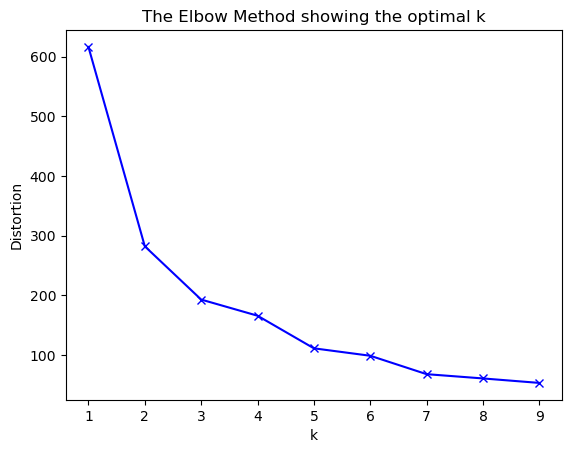

In [36]:
elbow_method(df2[['load_power_W']])

c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\awikt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


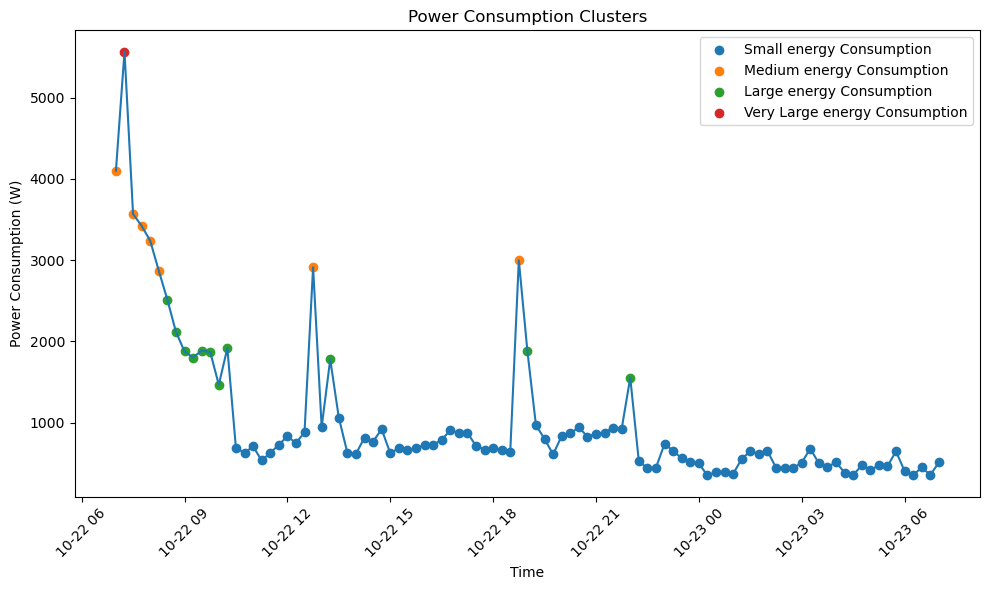

,Date_UTC,load_power_W,cluster
0,2022-10-21 18:00:00+00:00,4099.0,1
1,2022-10-21 18:15:00+00:00,5566.0,3
2,2022-10-21 18:30:00+00:00,3565.5,1
3,2022-10-21 18:45:00+00:00,3420.5,1
4,2022-10-21 19:00:00+00:00,3236.5,1
...,...,...,...
92,2022-10-22 17:00:00+00:00,402.5,0
93,2022-10-22 17:15:00+00:00,352.5,0
94,2022-10-22 17:30:00+00:00,447.5,0
95,2022-10-22 17:45:00+00:00,354.5,0


In [46]:

# # Convert to DataFrame
df2 = df[df['customerID'] == 793][:97]

# Assume we will try with 3 clusters (this number can be tuned based on the data)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
e_consumption_labels = ["Small energy Consumption", "Medium energy Consumption", "Large energy Consumption", "Very Large energy Consumption"]

# Fitting the model
df2['cluster'] = kmeans.fit_predict(df2[['load_power_W']])
# Visualizing the clusters
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_data = df2[df2['cluster'] == i]
    plt.scatter(cluster_data['Date_NZDT'],cluster_data['load_power_W'], label=e_consumption_labels[i])

plt.plot(df2['Date_NZDT'],df2['load_power_W'],)
plt.title('Power Consumption Clusters')
plt.xlabel('Time')
plt.ylabel('Power Consumption (W)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Returning the clustered DataFrame
df2[['Date_UTC', 'load_power_W', 'cluster']]

This code uses the `ruptures` library to generate a piecewise normal signal and detect change points in it. The detected change points can be interpreted as the times when an appliance was turned on or off.

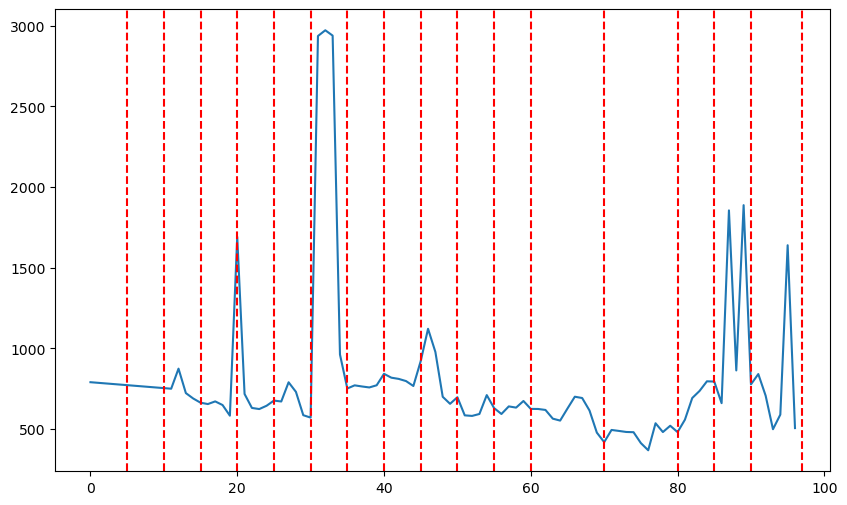

In [15]:
from ruptures import detection

# Select data
data = df_no_na_temp['load_power_W'][day(1)].values

# Change point detection
model = "l1"  # "l1", "rbf", "linear", "normal", "ar"
algo = detection.Pelt(model=model)
result = np.array(algo.fit_predict(data.reshape(-1,1), pen=10))

# Display
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data)
for xc in result:
    ax.axvline(x=xc, color='r', linestyle='--')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

# Select your data
data = df_no_na_temp['load_power_W'].values

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

# Prepare the data
X = df_no_na_temp['load_power_W'][0:10000].values  # input: mains readings
y = df_no_na_temp['load_power_W'][0:10000].values  # output: appliance readings

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(128, input_dim=1, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")


Epoch 1/10
250/250 [==============================] - 1s 953us/step - loss: 78090.8203
Epoch 2/10
250/250 [==============================] - 0s 913us/step - loss: 0.0233
Epoch 3/10
250/250 [==============================] - 0s 917us/step - loss: 0.0231
Epoch 4/10
250/250 [==============================] - 0s 903us/step - loss: 0.0224
Epoch 5/10
250/250 [==============================] - 0s 924us/step - loss: 0.0218
Epoch 6/10
250/250 [==============================] - 0s 903us/step - loss: 0.0203
Epoch 7/10
250/250 [==============================] - 0s 969us/step - loss: 0.0189
Epoch 8/10
250/250 [==============================] - 0s 912us/step - loss: 0.0184
Epoch 9/10
250/250 [==============================] - 0s 926us/step - loss: 0.0166
Epoch 10/10
63/63 [==============================] - 0s 863us/step - loss: 0.0147
Loss: 0.014679976738989353


4/4 [==============================] - 0s 2ms/step


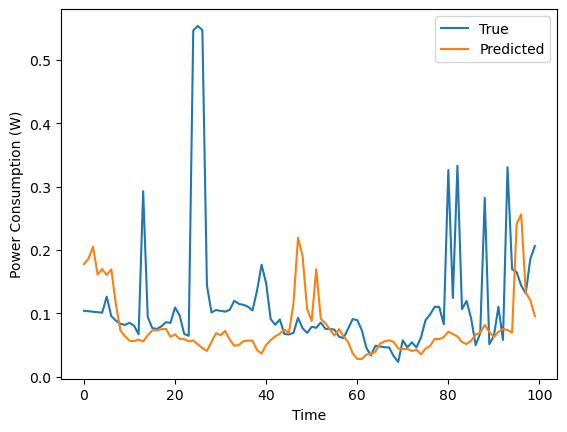

In [47]:

# Predict the appliance readings
X_new = X[-100:]  # last week of known data
y_pred = model.predict(X_new)

# Compare the predictions with the last week of known data
y_true = y[:100]

# Plot the true and predicted values
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Power Consumption (W)')
plt.legend()
plt.show()

Epoch 1/50
14/14 - 1s - loss: 0.0787 - 1s/epoch - 89ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0522 - 38ms/epoch - 3ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0547 - 41ms/epoch - 3ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0515 - 39ms/epoch - 3ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0520 - 41ms/epoch - 3ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0512 - 40ms/epoch - 3ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0514 - 42ms/epoch - 3ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0509 - 39ms/epoch - 3ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0509 - 43ms/epoch - 3ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0506 - 39ms/epoch - 3ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0506 - 42ms/epoch - 3ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0504 - 49ms/epoch - 4ms/step
Epoch 13/50
14/14 - 0s - loss: 0.0502 - 39ms/epoch - 3ms/step
Epoch 14/50
14/14 - 0s - loss: 0.0500 - 39ms/epoch - 3ms/step
Epoch 15/50
14/14 - 0s - loss: 0.0500 - 37ms/epoch - 3ms/step
Epoch 16/50
14/14 - 0s - loss: 0.0497 - 39ms/epoch - 3ms/step
Epoch 17/50
14/14 

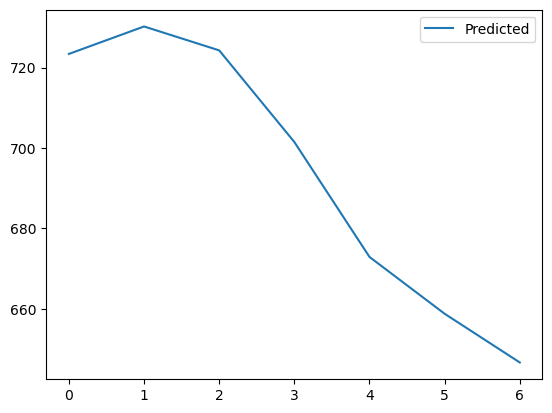

In [44]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df_no_na_temp['load_power_W'][:1000].values.reshape(-1, 1))

# Convert the series to a supervised learning problem
X, y = [], []
for i in range(7, len(data)):
    X.append(data[i-7:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)

# Reshape input to be 3D [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(loss='mae', optimizer='adam')

# Train the model
model.fit(X, y, epochs=50, batch_size=72, verbose=2, shuffle=False)

# Predict the next week of data
predictions = []
X_new = X[-1:]  # last week of known data

for _ in range(7):
    y_pred = model.predict(X_new)
    predictions.append(y_pred[0][0])  # append the predicted value to the list

    # update X_new to include the predicted value
    X_new = np.roll(X_new, -1)
    X_new[0][-1] = y_pred

# Denormalize the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot the predictions
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

4/4 [==============================] - 0s 2ms/step


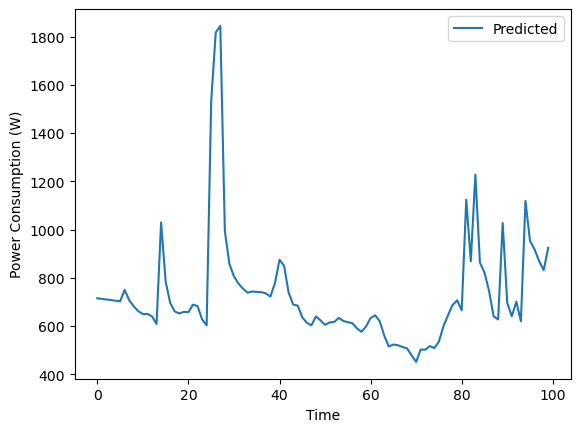

In [45]:
# Predict the first 100 entries
X_new = X[:100]  # first 100 entries of known data
predictions = model.predict(X_new)

# Denormalize the predictions
predictions = scaler.inverse_transform(predictions)

# Plot the predictions
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Power Consumption (W)')
plt.legend()
plt.show()

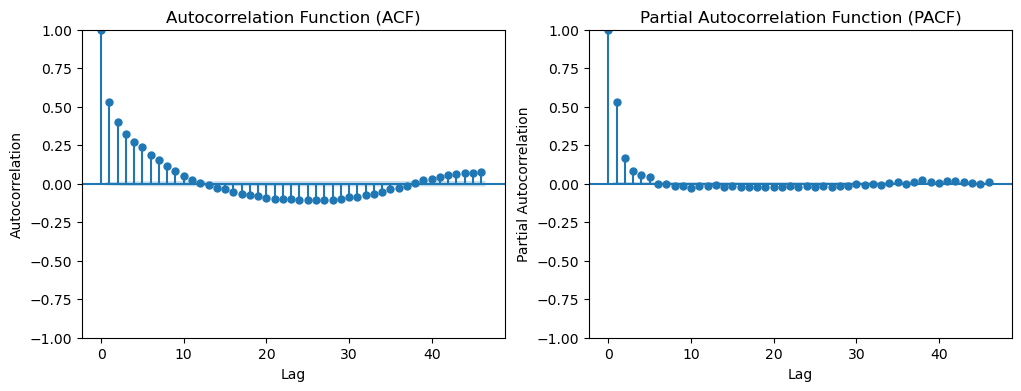

C:\Users\awikt\AppData\Local\Temp\ipykernel_17572\2514212759.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer.loc[:, 'Date_UTC'] = pd.to_datetime(df_customer['Date_UTC'])
C:\Users\awikt\AppData\Local\Temp\ipykernel_17572\2514212759.py:26: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_customer.loc[:, 'Date_UTC'] = pd.to_datetime(df_customer['Date_UTC'])


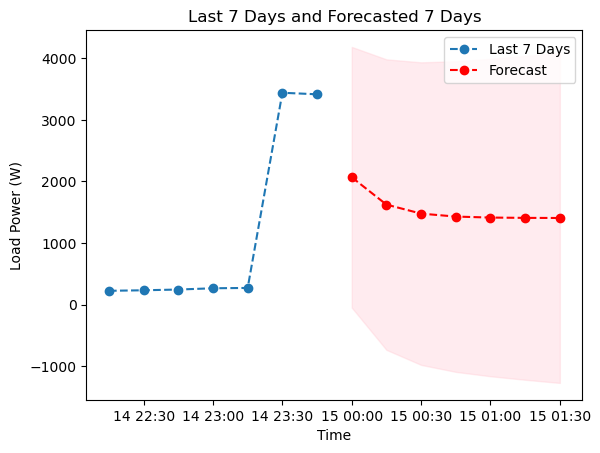

In [21]:
##SECOND PREDICTION MODEL

df_customer = df[df['customerID'] == 173]
result = adfuller(df_customer['load_power_W'])

# Check for stationarity based on the p-value
if result[1] > 0.05:
    df_customer = df_customer.diff().dropna()
#Visualize your data using ACF and PACF plots.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_customer['load_power_W'], ax=ax[0])
plot_pacf(df_customer['load_power_W'], ax=ax[1])

#Labelling the axes
# Label the axes
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_title('Autocorrelation Function (ACF)')

ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()

df_customer.loc[:, 'Date_UTC'] = pd.to_datetime(df_customer['Date_UTC'])

# Reset the index
df_customer.reset_index(drop=True, inplace=True)

#Fit ARIMA model:
p, d, q = 1, 1, 1  # Example values
model = ARIMA(df_customer['load_power_W'], order=(p, d, q))
results = model.fit()

#Make Predictions:  
#Steps is in days 
forecast = results.get_forecast(steps=7)

# Visualize the last 7 days of the original series and the forecasted 7 days.
last_7_days = df_customer['Date_UTC'].tail(7)
plt.plot(last_7_days, df_customer['load_power_W'].tail(7), label='Last 7 Days', linestyle='--', marker='o')

# Use the modified index to fill between the confidence intervals
forecast_dates = pd.date_range(last_7_days.max(), periods=7 + 1, freq='15T')[1:]
plt.plot(forecast_dates, forecast.predicted_mean, label='Forecast', color='red', linestyle='--', marker='o')

# Use the modified index to fill between the confidence intervals
plt.fill_between(forecast_dates, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)

# Set the x-axis ticks to match the dates
# plt.xticks(forecast_dates, rotation=45)
all_dates = pd.concat([last_7_days, forecast_dates.to_series()]) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))


# Label the axes
plt.xlabel('Time')
plt.ylabel('Load Power (W)')
plt.title('Last 7 Days and Forecasted 7 Days')

plt.legend()
plt.show()